<a href="https://colab.research.google.com/github/Maicastillo/ITBA/blob/main/test_de_wilcox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =========================================================
# Wilcoxon / Friedman incremental desde Google Sheets
# Autor: tú + ChatGPT
# =========================================================

# ------------------ CONFIG ------------------
SHEET_URL <- "https://docs.google.com/spreadsheets/d/1qA-9PXn2X9AMrgSXaSb_vwjVOZuZ7eaM/edit?usp=drive_link&ouid=106391851821647297659&rtpof=true&sd=true"
SHEET_NAME <- NULL        # usa NULL para leer la 1ª pestaña; o poné el nombre: "Hoja1"
paired_mode <- TRUE       # TRUE = apareado por semilla (Friedman + Wilcoxon pareado)
p_adjust_method <- "BH"   # "BH" (FDR), "bonferroni", etc.
export_resultados <- TRUE # TRUE = guarda CSVs en el WD

# ------------------ INSTALAR LIBRERÍAS SI FALTAN ------------------
install_if_missing <- function(pkgs) {
  to_install <- pkgs[!pkgs %in% rownames(installed.packages())]
  if (length(to_install)) install.packages(to_install, dependencies = TRUE)
}
install_if_missing(c("googlesheets4","tidyverse","rstatix","ggpubr"))

# ------------------ CARGAR LIBRERÍAS ------------------
suppressPackageStartupMessages({
  library(googlesheets4)
  library(tidyverse)
  library(rstatix)
  library(ggpubr)   # por si rstatix lo requiere
})

# Si el archivo es público, esto evita pedir login.
# Si NO es público, comentá la línea siguiente y corré gs4_auth() con tu cuenta.
gs4_deauth()

# ------------------ LECTURA DESDE GOOGLE SHEETS ------------------
if (is.null(SHEET_NAME)) {
  df_wide <- read_sheet(SHEET_URL, .name_repair = "minimal")
} else {
  df_wide <- read_sheet(SHEET_URL, sheet = SHEET_NAME, .name_repair = "minimal")
}

# Validaciones básicas
stopifnot(ncol(df_wide) >= 2)
workflow_col <- names(df_wide)[1]  # primera columna = nombre del workflow/escenario

# identificar columnas de semillas por patrón "Semilla X"
seed_cols <- grep("^Semilla\\s*\\d+$", names(df_wide), value = TRUE)
if (length(seed_cols) == 0) {
  stop("No encontré columnas de semillas con nombres tipo 'Semilla 1', 'Semilla 2', ... Revisá encabezados.")
}

# Forzar a numérico (limpiando separadores / signos que vengan como texto)
df_wide <- df_wide %>%
  mutate(across(all_of(seed_cols),
                ~ suppressWarnings(as.numeric(gsub("[^0-9.-]", "", as.character(.))))))

# ------------------ PASO A LARGO ------------------
df_long <- df_wide %>%
  pivot_longer(all_of(seed_cols), names_to = "Semilla", values_to = "Valor") %>%
  mutate(
    Semilla  = str_replace(Semilla, "Semilla\\s*", "") |> as.integer(),
    Workflow = .data[[workflow_col]] |> as.factor()
  ) %>%
  select(Workflow, Semilla, Valor) %>%
  arrange(Semilla, Workflow)

# ------------------ FUNCIONES DE TEST ------------------
`%||%` <- function(x, y) if (is.null(x)) y else x

global_tests_progress <- function(dat, paired_by_seed = TRUE) {
  seeds <- sort(unique(dat$Semilla))
  map_dfr(seq_along(seeds), function(k) {
    sub <- dat |> filter(Semilla %in% seeds[1:k])
    if (paired_by_seed) {
      g <- friedman_test(sub, Valor ~ Workflow | Semilla)
      tibble(k = k, semillas_usadas = k, stat = g$statistic, p_value = g$p)
    } else {
      g <- kruskal_test(sub, Valor ~ Workflow)
      tibble(k = k, semillas_usadas = k, stat = g$statistic, p_value = g$p)
    }
  })
}

pairwise_wilcox_progress <- function(dat, paired_by_seed = TRUE, p_adjust = "BH") {
  seeds <- sort(unique(dat$Semilla))
  wfs <- levels(dat$Workflow)
  pairs <- combn(wfs, 2, simplify = FALSE)

  map_dfr(seq_along(seeds), function(k) {
    sub <- dat |> filter(Semilla %in% seeds[1:k])

    raw <- map_dfr(pairs, function(pr) {
      a <- pr[1]; b <- pr[2]
      if (paired_by_seed) {
        xa <- sub |> filter(Workflow == a) |> arrange(Semilla) |> pull(Valor)
        xb <- sub |> filter(Workflow == b) |> arrange(Semilla) |> pull(Valor)
        wt <- suppressWarnings(wilcox.test(xa, xb, paired = TRUE, exact = FALSE))
      } else {
        wt <- suppressWarnings(wilcox.test(Valor ~ Workflow,
                                           data = sub |> filter(Workflow %in% c(a,b)),
                                           paired = FALSE, exact = FALSE))
      }
      tibble(k = k,
             pair = paste(a, b, sep = " vs "),
             p_raw = wt$p.value,
             W_stat = wt$statistic %||% NA_real_)
    })

    raw %>% mutate(p_adj = p.adjust(p_raw, method = p_adjust))
  })
}

# ------------------ CORRER TESTS ------------------
global_prog   <- global_tests_progress(df_long, paired_by_seed = paired_mode)
pairwise_prog <- pairwise_wilcox_progress(df_long, paired_by_seed = paired_mode, p_adjust = p_adjust_method)

cat("\n=== GLOBAL (", ifelse(paired_mode, "Friedman apareado por semilla", "Kruskal–Wallis no apareado"), ") ===\n", sep = "")
print(global_prog)

cat("\n=== PAIRWISE WILCOXON (p-ajustado ", p_adjust_method, ") ===\n", sep = "")
pairwise_summary <- pairwise_prog %>% group_by(k) %>% slice_min(order_by = p_adj, n = 1, with_ties = FALSE)
print(pairwise_summary)

# ------------------ GRÁFICOS ------------------
# 1) p-value global vs # semillas
p1 <- ggplot(global_prog, aes(x = semillas_usadas, y = p_value)) +
  geom_line(linewidth = 1) +
  geom_point(size = 2) +
  geom_hline(yintercept = 0.05, linetype = 2) +
  labs(title = "p-value global vs. # de semillas",
       x = "# de semillas acumuladas",
       y = "p-value (global)") +
  theme_minimal(base_size = 12)

# 2) Mínimo p-ajustado entre pares vs # semillas
pairwise_min <- pairwise_summary %>% select(k, pair, p_adj)
p2 <- ggplot(pairwise_min, aes(x = k, y = p_adj)) +
  geom_line(linewidth = 1) +
  geom_point(size = 2) +
  geom_hline(yintercept = 0.05, linetype = 2) +
  labs(title = "Mínimo p-ajustado (Wilcoxon) entre pares vs. # de semillas",
       x = "# de semillas acumuladas",
       y = "p-ajustado (BH)") +
  theme_minimal(base_size = 12)

# 3) Heatmap final de p-ajustados (todas las semillas)
pairwise_final <- pairwise_prog %>% filter(k == max(k))
heat <- pairwise_final %>%
  separate(pair, into = c("A","B"), sep = " vs ") %>%
  mutate(A = factor(A, levels = levels(df_long$Workflow)),
         B = factor(B, levels = levels(df_long$Workflow))) %>%
  complete(A, B) %>%               # cuadrícula completa
  mutate(value = ifelse(is.na(p_adj), 1, p_adj))

p3 <- ggplot(heat, aes(A, B, fill = value)) +
  geom_tile(color = "white") +
  scale_fill_gradient(limits = c(0,1), low = "white", high = "steelblue") +
  geom_text(aes(label = ifelse(is.na(value), "", scales::number(value, accuracy = 0.001)))) +
  labs(title = "Heatmap p-values ajustados (todas las semillas)",
       x = "Workflow", y = "Workflow", fill = "p-ajustado") +
  theme_minimal(base_size = 12)

# Mostrar gráficos
print(p1); print(p2); print(p3)

# ------------------ EXPORTS OPCIONALES ------------------
if (export_resultados) {
  write.csv(global_prog,   "wilcox_global_progress.csv", row.names = FALSE)
  write.csv(pairwise_prog, "wilcox_pairwise_progress.csv", row.names = FALSE)
  message("CSV guardados: wilcox_global_progress.csv, wilcox_pairwise_progress.csv")
}

# ------------------ NOTAS ------------------
# - Si agregás nuevas columnas "Semilla 6", "Semilla 7", etc., el script las toma solo.
# - Para modo NO apareado por semilla, seteá paired_mode <- FALSE al inicio.
# - Si tu hoja NO es pública, autenticá con: googlesheets4::gs4_auth()


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘Deriv’, ‘microbenchmark’, ‘Rdpack’, ‘zoo’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘RcppEigen’, ‘TH.data’, ‘sandwich’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘estimability’, ‘mvtnorm’, ‘numDeriv’, ‘libcoin’, ‘matrixStats’, ‘modeltools’, ‘multcomp’, ‘hunspell’, ‘corrplot’, ‘car’, ‘emmeans’, ‘coin’, ‘spelling’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’


Warning message in install.packages(to_install, dependencies = TRUE):
“installation of package ‘cowplot’ had non-zero exit status”
Warning message in install.packages(to_install, dependencies = TRUE):
“installation of package ‘doBy’ had non-zero exit status”
Warning message in install.packages(to_install, dependencies = TRUE):
“installation of package ‘pbkrtest’ had non-zero exit status”
Warning message in install.packages(to_install,

ERROR: Error in library(rstatix): there is no package called ‘rstatix’


In [2]:
install.packages(c("googlesheets4","dplyr","tidyr","ggplot2","stringr","purrr","tibble","readr"))


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [4]:
# =========================================================
# Lectura robusta desde Google Drive + Tests incrementales
# (Friedman/Kruskal + Wilcoxon) SIN rstatix
# =========================================================

# ------------------ CONFIG ------------------
SHEET_URL <- "https://docs.google.com/spreadsheets/d/1qA-9PXn2X9AMrgSXaSb_vwjVOZuZ7eaM/edit?usp=drive_link&ouid=106391851821647297659&rtpof=true&sd=true"
SHEET_NAME <- NULL        # NULL = 1ª pestaña; o "Hoja1", etc.
paired_mode <- TRUE       # TRUE = apareado por semilla (recomendado)
p_adjust_method <- "BH"   # "BH", "bonferroni", etc.
export_resultados <- TRUE # guarda CSVs en el WD

# ------------------ LIBRERÍAS ------------------
suppressPackageStartupMessages({
  library(googlesheets4)
  library(googledrive)
  library(readxl)
  library(dplyr)
  library(tidyr)
  library(ggplot2)
  library(stringr)
  library(purrr)
  library(tibble)
})

# ------------------ UTIL: lectura robusta ------------------
read_any_sheet <- function(url, sheet = NULL, prefer_public = TRUE) {
  # 1) Intento lectura pública (sin login), si se pide
  if (prefer_public) {
    try({
      gs4_deauth()
    }, silent = TRUE)
    out <- try(
      { if (is.null(sheet)) read_sheet(url, .name_repair = "minimal")
        else read_sheet(url, sheet = sheet, .name_repair = "minimal") },
      silent = TRUE
    )
    if (!inherits(out, "try-error")) return(out)
  }

  # 2) Autenticación y detección del tipo de archivo
  message("→ Autenticando con Google (seleccioná tu cuenta si te lo pide)…")
  suppressMessages(gs4_auth())        # token para Sheets API
  suppressMessages(drive_auth())      # token para Drive API

  # Resolver si es shortcut y obtener mimeType
  drv <- drive_get(url)
  if (nrow(drv) == 0) stop("No se pudo resolver el recurso en Drive. Verificá el link / permisos.")
  drv <- drive_reveal(drv, "mime_type")
  mime <- drv$mime_type[1]

  # Si es atajo (shortcut), seguir el destino
  if (mime == "application/vnd.google-apps.shortcut") {
    drv <- drive_reveal(drv, "shortcut_details")
    target_id <- drv$shortcut_details$targetId[[1]]
    if (is.na(target_id) || !nzchar(target_id)) stop("El atajo no tiene destino válido.")
    drv <- drive_get(as_id(target_id)) %>% drive_reveal("mime_type")
    mime <- drv$mime_type[1]
  }

  # 3) Leer según tipo
  if (mime == "application/vnd.google-apps.spreadsheet") {
    # Es un Google Sheet real
    ssid <- as_sheets_id(drv$id)
    out <- if (is.null(sheet)) read_sheet(ssid, .name_repair = "minimal")
           else read_sheet(ssid, sheet = sheet, .name_repair = "minimal")
    return(out)
  }

  if (mime %in% c("application/vnd.openxmlformats-officedocument.spreadsheetml.sheet",
                  "application/vnd.ms-excel")) {
    # Es un Excel almacenado en Drive
    tf <- tempfile(fileext = ifelse(grepl("openxml", mime), ".xlsx", ".xls"))
    suppressMessages(drive_download(drv, path = tf, overwrite = TRUE))
    out <- readxl::read_excel(tf, sheet = sheet %||% 1)
    # convertir a tibble con nombres "limpios"
    out <- as_tibble(out)
    names(out) <- make.names(names(out), unique = TRUE)
    return(out)
  }

  stop(paste0("El archivo no es un Google Sheet ni un Excel (mime_type = ", mime, ")."))
}

`%||%` <- function(x, y) if (is.null(x)) y else x

# ------------------ LECTURA DE DATOS ------------------
df_wide <- read_any_sheet(SHEET_URL, sheet = SHEET_NAME, prefer_public = TRUE)

stopifnot(ncol(df_wide) >= 2)
workflow_col <- names(df_wide)[1]  # primera columna = workflows/escenarios

# Columnas de semillas con patrón "Semilla X"
seed_cols <- grep("^Semilla\\s*\\d+$", names(df_wide), value = TRUE)
if (length(seed_cols) == 0) stop("No encontré columnas tipo 'Semilla 1', 'Semilla 2', ...")

# Limpiar y forzar numérico
df_wide <- df_wide %>%
  mutate(across(all_of(seed_cols),
                ~ suppressWarnings(as.numeric(gsub("[^0-9.-]", "", as.character(.))))))

# ------------------ PASO A LARGO ------------------
df_long <- df_wide %>%
  pivot_longer(all_of(seed_cols), names_to = "Semilla", values_to = "Valor") %>%
  mutate(
    Semilla  = as.integer(str_replace(Semilla, "Semilla\\s*", "")),
    Workflow = factor(.data[[workflow_col]])
  ) %>%
  select(Workflow, Semilla, Valor) %>%
  arrange(Semilla, Workflow)

# ------------------ HELPERS: balanceo por bloque ------------------
n_wf <- nlevels(df_long$Workflow)

balance_by_seed <- function(dat) {
  # Mantener solo semillas que tengan TODOS los workflows (requerido por Friedman)
  seeds_ok <- dat %>% count(Semilla) %>% filter(n == n_wf) %>% pull(Semilla)
  dat %>% filter(Semilla %in% seeds_ok)
}

# ------------------ TESTS GLOBALES INCREMENTALES ------------------
global_tests_progress <- function(dat, paired_by_seed = TRUE) {
  seeds <- sort(unique(dat$Semilla))
  map_dfr(seq_along(seeds), function(k) {
    sub <- dat %>% filter(Semilla %in% seeds[1:k])
    if (paired_by_seed) {
      subb <- balance_by_seed(sub)
      if (nrow(subb) == 0 || length(unique(subb$Semilla)) < 2) {
        return(tibble(k=k, semillas_usadas=k, stat=NA_real_, p_value=NA_real_))
      }
      gt <- tryCatch(
        friedman.test(Valor ~ Workflow | Semilla, data = subb),
        error = function(e) NULL
      )
      tibble(k = k,
             semillas_usadas = k,
             stat = if (is.null(gt)) NA_real_ else unname(gt$statistic),
             p_value = if (is.null(gt)) NA_real_ else gt$p.value)
    } else {
      gt <- tryCatch(
        kruskal.test(Valor ~ Workflow, data = sub),
        error = function(e) NULL
      )
      tibble(k = k,
             semillas_usadas = k,
             stat = if (is.null(gt)) NA_real_ else unname(gt$statistic),
             p_value = if (is.null(gt)) NA_real_ else gt$p.value)
    }
  })
}

# ------------------ TESTS PAREADOS (WILCOXON) INCREMENTALES ------------------
pairwise_wilcox_progress <- function(dat, paired_by_seed = TRUE, p_adjust = "BH") {
  seeds <- sort(unique(dat$Semilla))
  wfs <- levels(dat$Workflow)
  pairs <- combn(wfs, 2, simplify = FALSE)

  map_dfr(seq_along(seeds), function(k) {
    sub <- dat %>% filter(Semilla %in% seeds[1:k])

    res <- map_dfr(pairs, function(pr) {
      a <- pr[1]; b <- pr[2]
      if (paired_by_seed) {
        A <- sub %>% filter(Workflow == a) %>% select(Semilla, Valor) %>% rename(A = Valor)
        B <- sub %>% filter(Workflow == b) %>% select(Semilla, Valor) %>% rename(B = Valor)
        J <- inner_join(A, B, by = "Semilla") %>% arrange(Semilla)
        if (nrow(J) < 1) {
          return(tibble(k = k, pair = paste(a, "vs", b), p_raw = NA_real_, W_stat = NA_real_))
        }
        wt <- tryCatch(
          wilcox.test(J$A, J$B, paired = TRUE, exact = FALSE),
          error = function(e) NULL
        )
        tibble(k = k,
               pair = paste(a, "vs", b),
               p_raw = if (is.null(wt)) NA_real_ else wt$p.value,
               W_stat = if (is.null(wt)) NA_real_ else unname(wt$statistic))
      } else {
        sub2 <- sub %>% filter(Workflow %in% c(a,b)) %>% droplevels()
        wt <- tryCatch(
          wilcox.test(Valor ~ Workflow, data = sub2, paired = FALSE, exact = FALSE),
          error = function(e) NULL
        )
        tibble(k = k,
               pair = paste(a, "vs", b),
               p_raw = if (is.null(wt)) NA_real_ else wt$p.value,
               W_stat = if (is.null(wt)) NA_real_ else unname(wt$statistic))
      }
    })

    res %>% mutate(p_adj = p.adjust(p_raw, method = p_adjust))
  })
}

# ------------------ CORRER TESTS ------------------
global_prog   <- global_tests_progress(df_long, paired_by_seed = paired_mode)
pairwise_prog <- pairwise_wilcox_progress(df_long, paired_by_seed = paired_mode, p_adjust = p_adjust_method)

cat("\n=== GLOBAL (", ifelse(paired_mode, "Friedman (apareado por Semilla)", "Kruskal–Wallis (no apareado)"), ") ===\n", sep = "")
print(global_prog)

cat("\n=== PAREO WILCOXON (ajuste ", p_adjust_method, ") ===\n", sep = "")
pairwise_summary <- pairwise_prog %>% group_by(k) %>% slice_min(order_by = p_adj, n = 1, with_ties = FALSE)
print(pairwise_summary)

# ------------------ GRÁFICOS ------------------
# 1) p-value global vs # semillas
p1 <- ggplot(global_prog, aes(x = semillas_usadas, y = p_value)) +
  geom_line(linewidth = 1) +
  geom_point(size = 2) +
  geom_hline(yintercept = 0.05, linetype = 2) +
  labs(title = "p-value global vs. # de semillas",
       x = "# de semillas acumuladas", y = "p-value (global)") +
  theme_minimal(base_size = 12)

# 2) Mínimo p-ajustado entre pares vs # semillas
pairwise_min <- pairwise_summary %>% select(k, pair, p_adj)
p2 <- ggplot(pairwise_min, aes(x = k, y = p_adj)) +
  geom_line(linewidth = 1) +
  geom_point(size = 2) +
  geom_hline(yintercept = 0.05, linetype = 2) +
  labs(title = "Mínimo p-ajustado (Wilcoxon) entre pares vs. # de semillas",
       x = "# de semillas acumuladas", y = "p-ajustado (BH)") +
  theme_minimal(base_size = 12)

# 3) Heatmap final (todas las semillas)
pairwise_final <- pairwise_prog %>% filter(k == max(k))
heat <- pairwise_final %>%
  tidyr::separate(pair, into = c("A","B"), sep = " vs ") %>%
  mutate(A = factor(A, levels = levels(df_long$Workflow)),
         B = factor(B, levels = levels(df_long$Workflow))) %>%
  complete(A, B) %>%
  mutate(value = ifelse(is.na(p_adj), 1, p_adj))

p3 <- ggplot(heat, aes(A, B, fill = value)) +
  geom_tile(color = "white") +
  scale_fill_gradient(limits = c(0,1), low = "white", high = "steelblue") +
  geom_text(aes(label = ifelse(is.na(value), "", scales::number(value, accuracy = 0.001)))) +
  labs(title = "Heatmap p-values ajustados (todas las semillas)",
       x = "Workflow", y = "Workflow", fill = "p-ajustado") +
  theme_minimal(base_size = 12)

print(p1); print(p2); print(p3)

# ------------------ EXPORTS OPCIONALES ------------------
if (export_resultados) {
  write.csv(global_prog,   "global_progress.csv", row.names = FALSE)
  write.csv(pairwise_prog, "pairwise_progress.csv", row.names = FALSE)
  message("CSV guardados: global_progress.csv, pairwise_progress.csv")
}


→ Autenticando con Google (seleccioná tu cuenta si te lo pide)…




=== Wilcoxon entre w1 y w2 ===
Paired: TRUE 

	Wilcoxon signed rank test with continuity correction

data:  ab$a and ab$b
V = 12, p-value = 0.2807
alternative hypothesis: true location shift is not equal to 0

Mediana(dif = w1 - w2): 384 

=== Progreso p-value (1…K) para w1 vs w2 ===
  k   p_value
1 1 1.0000000
2 2 0.3710934
3 3 1.0000000
4 4 0.5838824
5 5 0.2807127


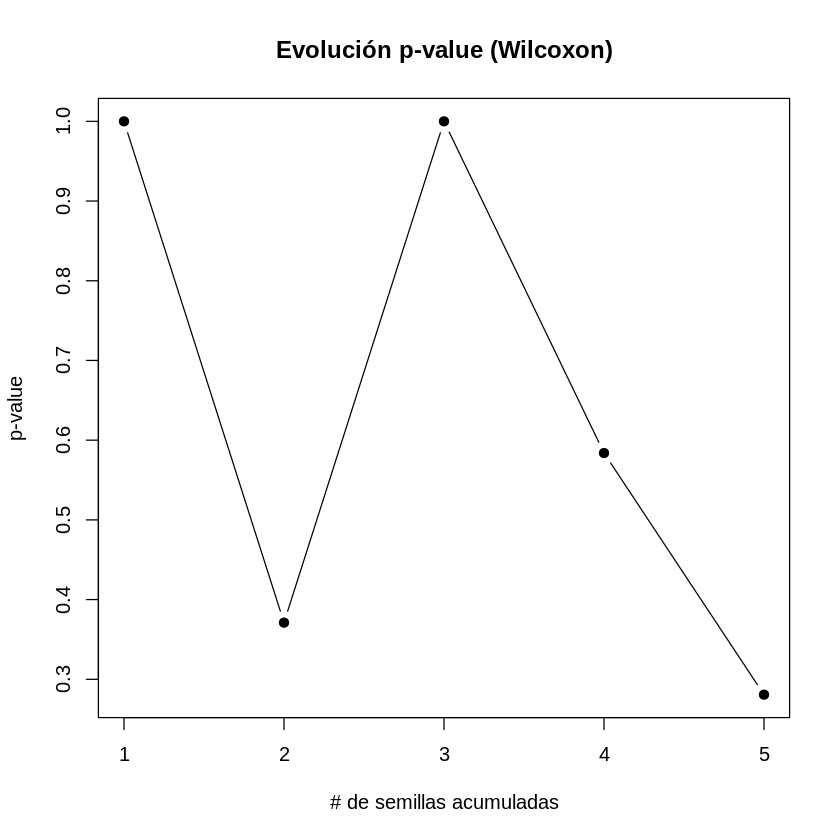

In [7]:
# =========================================================
# Wilcoxon "simple" con datos cargados a mano (sin paquetes extra)
# =========================================================

## 1) PEGÁ TUS DATOS ACÁ ---------------------------------
## Ejemplo: reemplazá por tus números (una observación por semilla)
## Si es "pareado", ambos vectores deben corresponder a las mismas semillas.
w1 <- c(3349,3467,4353,4209,3503)  # Workflow 1
w2 <- c(3664,3686,3969,3799,2749)  # Workflow 2
w3 <- c(2897,3572,3831,2997,3625)  # Workflow 3
w4 <- c(3347,3933,3743,3869,3073)  # Workflow 4
w5 <- c(3672,3840,4667,4029,4422)  # Workflow 5



## Si querés comparar más de dos workflows, agregá más vectores:
## w3 <- c(...)
## w4 <- c(...)
## y más abajo usás la sección "pairwise" opcional.


## 2) WILCOXON ENTRE DOS WORKFLOWS ------------------------
## Cambiá 'paired' a TRUE si tus semillas son las mismas en ambos (recomendado).
paired <- TRUE

# Emparejar longitudes y remover NAs de ambos lados
.align_vectors <- function(a, b) {
  n <- min(length(a), length(b))
  a <- a[seq_len(n)]
  b <- b[seq_len(n)]
  ok <- is.finite(a) & is.finite(b)
  list(a = a[ok], b = b[ok])
}

ab <- .align_vectors(w1, w2)

# Test Wilcoxon
wt <- wilcox.test(ab$a, ab$b, paired = paired, exact = FALSE, alternative = "two.sided")

cat("\n=== Wilcoxon entre w1 y w2 ===\n")
cat("Paired:", paired, "\n")
print(wt)

# Dirección/mediana de las diferencias (útil cuando es pareado)
if (paired) {
  dif <- ab$a - ab$b
  cat("Mediana(dif = w1 - w2):", median(dif, na.rm = TRUE), "\n")
}


## 3) EVOLUCIÓN INCREMENTAL DEL p-VALUE (1…K semillas) ----
wilcox_progress <- function(x, y, paired = TRUE) {
  res <- data.frame(k = integer(), p_value = numeric(), stringsAsFactors = FALSE)
  n <- min(length(x), length(y))
  for (k in seq_len(n)) {
    sub <- .align_vectors(x[1:k], y[1:k])
    if (length(sub$a) < 1) next
    wt <- tryCatch(wilcox.test(sub$a, sub$b, paired = paired, exact = FALSE),
                   error = function(e) NULL)
    p <- if (is.null(wt)) NA_real_ else wt$p.value
    res <- rbind(res, data.frame(k = k, p_value = p))
  }
  res
}

prog <- wilcox_progress(w1, w2, paired = paired)
cat("\n=== Progreso p-value (1…K) para w1 vs w2 ===\n")
print(prog)

# Plot base (opcional)
plot(prog$k, prog$p_value, type = "b", pch = 19,
     xlab = "# de semillas acumuladas", ylab = "p-value",
     main = "Evolución p-value (Wilcoxon)")
abline(h = 0.05, lty = 2, col = "gray")


## 4) (OPCIONAL) WILCOXON ENTRE MUCHOS WORKFLOWS EN PARES -
## Cargá todos tus workflows como una lista nombrada:
datos <- list(W1 = w1, W2 = w2, W3 = w3, W4 = w4,W5 = w5)
## y elegí si es pareado (mismas semillas para todos) o no.

pairwise_wilcox <- function(datos, paired = TRUE, p_adjust = "BH") {
  nms <- names(datos)
  if (is.null(nms)) nms <- paste0("WF", seq_along(datos))
  names(datos) <- nms

  comb <- t(combn(nms, 2))
  out <- data.frame(
    A = comb[,1], B = comb[,2],
    p_raw = NA_real_, W_stat = NA_real_, stringsAsFactors = FALSE
  )

  for (i in seq_len(nrow(out))) {
    a <- datos[[ out$A[i] ]]
    b <- datos[[ out$B[i] ]]
    ab <- .align_vectors(a, b)
    wt <- tryCatch(wilcox.test(ab$a, ab$b, paired = paired, exact = FALSE),
                   error = function(e) NULL)
    out$p_raw[i]  <- if (is.null(wt)) NA_real_ else wt$p.value
    out$W_stat[i] <- if (is.null(wt)) NA_real_ else unname(wt$statistic)
  }

  out$p_adj <- p.adjust(out$p_raw, method = p_adjust)
  out[order(out$p_adj), ]
}

## Ejemplo de uso (descomentá si querés):
## datos <- list(W1 = w1, W2 = w2)  # agregá W3 = w3, etc.
## res_pairs <- pairwise_wilcox(datos, paired = TRUE, p_adjust = "BH")
## print(res_pairs)




=== Wilcoxon todos vs todos (ajuste BH) ===
    A  B      p_raw W_stat     p_adj
4  W1 W5 0.10564543      1 0.2641136
7  W2 W5 0.05905823      0 0.2641136
9  W3 W5 0.05905823      0 0.2641136
10 W4 W5 0.10564543      1 0.2641136
1  W1 W2 0.28071267     12 0.4678544
2  W1 W3 0.28071267     12 0.4678544
3  W1 W4 0.41849223     11 0.5978460
5  W2 W3 0.58963855     10 0.6551539
8  W3 W4 0.58963855      5 0.6551539
6  W2 W4 0.78740649      6 0.7874065

=== Mínimo p-ajustado por K entre todos los pares ===
  k     p_adj
1 1 1.0000000
2 2 0.6184889
3 3 0.4536230
4 4 0.2874895
5 5 0.2641136

=== Matriz de p-ajustados (todas las semillas) ===
       W1     W2     W3     W4     W5
W1 0.0000 0.4679 0.4679 0.5978 0.2641
W2 0.4679 0.0000 0.6552 0.7874 0.2641
W3 0.4679 0.6552 0.0000 0.6552 0.2641
W4 0.5978 0.7874 0.6552 0.0000 0.2641
W5 0.2641 0.2641 0.2641 0.2641 0.0000

=== Pares significativos (p-aj < 0.05) ===
Ninguno


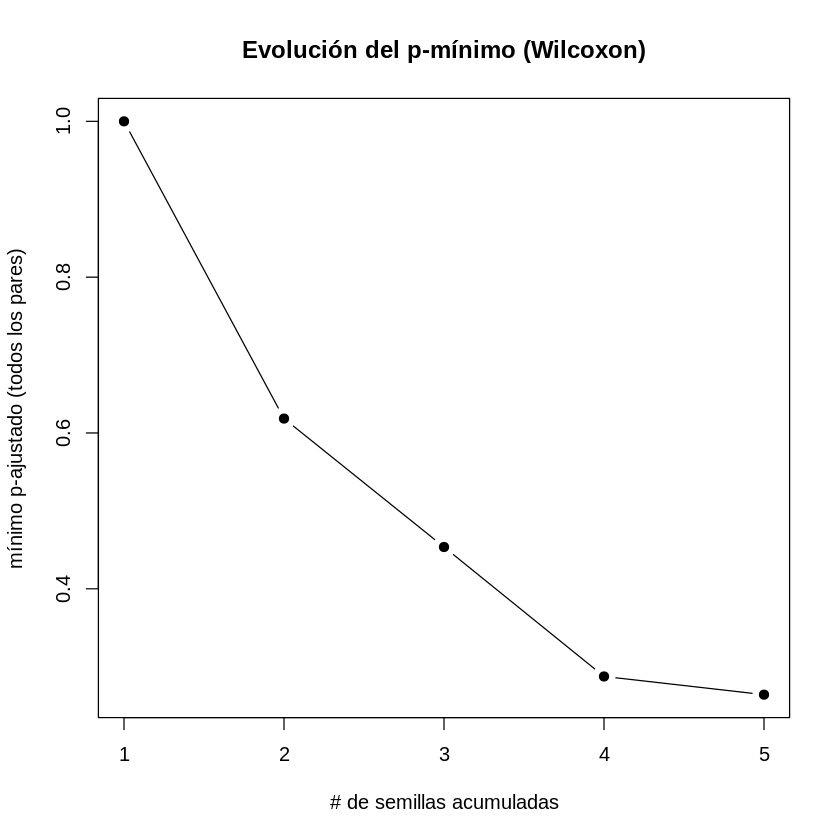

In [8]:
# =================== DATOS ===================
w1 <- c(3349,3467,4353,4209,3503)
w2 <- c(3664,3686,3969,3799,2749)
w3 <- c(2897,3572,3831,2997,3625)
w4 <- c(3347,3933,3743,3869,3073)
w5 <- c(3672,3840,4667,4029,4422)

datos <- list(W1 = w1, W2 = w2, W3 = w3, W4 = w4, W5 = w5)

# =================== CONFIG ==================
paired <- TRUE       # TRUE = mismas semillas en todos los workflows
p_adjust <- "BH"     # ajuste de p-values (BH recomendado)

# =================== HELPERS =================
.align_vectors <- function(a, b) {
  n <- min(length(a), length(b))
  a <- a[seq_len(n)]; b <- b[seq_len(n)]
  ok <- is.finite(a) & is.finite(b)
  list(a = a[ok], b = b[ok])
}

# --- 1) TODOS vs TODOS (con todas las semillas) -----------
pairwise_wilcox_all <- function(datos, paired = TRUE, p_adjust = "BH") {
  nms <- names(datos); if (is.null(nms)) nms <- paste0("WF", seq_along(datos))
  names(datos) <- nms
  comb <- t(combn(nms, 2))
  out <- data.frame(A = comb[,1], B = comb[,2],
                    p_raw = NA_real_, W_stat = NA_real_,
                    stringsAsFactors = FALSE)
  for (i in seq_len(nrow(out))) {
    a <- datos[[ out$A[i] ]]; b <- datos[[ out$B[i] ]]
    ab <- .align_vectors(a, b)
    wt <- tryCatch(wilcox.test(ab$a, ab$b, paired = paired, exact = FALSE),
                   error = function(e) NULL)
    out$p_raw[i]  <- if (is.null(wt)) NA_real_ else wt$p.value
    out$W_stat[i] <- if (is.null(wt)) NA_real_ else unname(wt$statistic)
  }
  out$p_adj <- p.adjust(out$p_raw, method = p_adjust)
  out[order(out$p_adj), ]
}

# --- 2) TODOS vs TODOS, INCREMENTAL por K -----------------
pairwise_wilcox_incremental <- function(datos, paired = TRUE, p_adjust = "BH") {
  nms <- names(datos); if (is.null(nms)) nms <- paste0("WF", seq_along(datos))
  names(datos) <- nms
  K <- min(sapply(datos, length))            # hasta la longitud común mínima
  comb <- t(combn(nms, 2))
  res_all <- list()

  for (k in seq_len(K)) {
    tmp <- data.frame(k = k, A = comb[,1], B = comb[,2],
                      p_raw = NA_real_, W_stat = NA_real_,
                      stringsAsFactors = FALSE)
    for (i in seq_len(nrow(tmp))) {
      a <- datos[[ tmp$A[i] ]][1:k]
      b <- datos[[ tmp$B[i] ]][1:k]
      ab <- .align_vectors(a, b)
      wt <- tryCatch(wilcox.test(ab$a, ab$b, paired = paired, exact = FALSE),
                     error = function(e) NULL)
      tmp$p_raw[i]  <- if (is.null(wt)) NA_real_ else wt$p.value
      tmp$W_stat[i] <- if (is.null(wt)) NA_real_ else unname(wt$statistic)
    }
    tmp$p_adj <- p.adjust(tmp$p_raw, method = p_adjust)  # ajuste dentro de cada K
    res_all[[k]] <- tmp
  }
  do.call(rbind, res_all)
}

# --- 3) Matriz de p-values (útil para “heatmap” de texto) -
pvalue_matrix <- function(res, use_adjusted = TRUE, last_only = FALSE) {
  if ("k" %in% names(res) && last_only) res <- res[res$k == max(res$k), ]
  nms <- sort(unique(c(res$A, res$B)))
  mat <- matrix(NA_real_, nrow = length(nms), ncol = length(nms),
                dimnames = list(nms, nms))
  pv <- if (use_adjusted && "p_adj" %in% names(res)) res$p_adj else res$p_raw
  for (i in seq_len(nrow(res))) {
    a <- res$A[i]; b <- res$B[i]
    mat[a, b] <- mat[b, a] <- pv[i]
  }
  diag(mat) <- 0
  mat
}

# =================== EJECUCIÓN ==================
# (a) todos vs todos con todas las semillas
res_pairs <- pairwise_wilcox_all(datos, paired = paired, p_adjust = p_adjust)
cat("\n=== Wilcoxon todos vs todos (ajuste ", p_adjust, ") ===\n", sep = "")
print(res_pairs)

# (b) incremental por K
res_prog <- pairwise_wilcox_incremental(datos, paired = paired, p_adjust = p_adjust)

cat("\n=== Mínimo p-ajustado por K entre todos los pares ===\n")
min_prog <- aggregate(p_adj ~ k, data = res_prog, FUN = function(x) min(x, na.rm = TRUE))
print(min_prog)

# Plot base del p-mínimo por K (opcional)
plot(min_prog$k, min_prog$p_adj, type = "b", pch = 19,
     xlab = "# de semillas acumuladas", ylab = "mínimo p-ajustado (todos los pares)",
     main = "Evolución del p-mínimo (Wilcoxon)")
abline(h = 0.05, lty = 2, col = "gray")

# (c) matriz final de p-valores ajustados (todas las semillas)
cat("\n=== Matriz de p-ajustados (todas las semillas) ===\n")
final_mat <- pvalue_matrix(res_prog, use_adjusted = TRUE, last_only = TRUE)
print(round(final_mat, 4))

# Pares “significativos” a 0.05 (si los hay)
sig <- subset(res_pairs, !is.na(p_adj) & p_adj < 0.05)
cat("\n=== Pares significativos (p-aj < 0.05) ===\n")
if (nrow(sig)) print(sig) else cat("Ninguno\n")
